In [ ]:
# All the imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.linear_model import Lasso, LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import mean_squared_error, accuracy_score,f1_score

In [ ]:
# Get the csv file
df = pd.read_csv('Kaggle_Salary.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (73,77,114,146,153,171,175,212,224,228,231) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1.0 Data Cleaning and Exploratory

In [ ]:
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"30,000-39,999",$0 (USD),Twitter (data science influencers),NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,NaN,Coursera,NaN,DataCamp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,-1,"5,000-7,499","> $100,000 ($USD)",NaN,NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)","Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",NaN,NaN,NaN,NaN,-1,NaN,Coursera,NaN,DataCamp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"250,000-299,999","$10,000-$99,999",NaN,NaN,NaN,NaN,NaN,NaN,"Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,"Slack Communities (ods.ai, kagglenoobs, etc)",NaN,NaN,-1,NaN,Coursera,edX,DataCamp,NaN,...,NaN,Azure Machine Learning Studio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14,">250,000"
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"4,000-4,999",$0 (USD),NaN,NaN,NaN,NaN,NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",NaN,"Blogs (Towards Data Science, Medium, Analytics...",NaN,NaN,NaN,Other,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
4,470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,"We have well established ML methods (i.e., mod...",NaN,NaN,Build prototypes to explore applying machine l...,NaN,NaN,Do research that advances the state of the art...,NaN,NaN,-1,"60,000-69,999","$10,000-$99,999",NaN,NaN,NaN,NaN,NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,RapidMiner,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,Auto-Keras,NaN,NaN,NaN,Na

##### By observing the original csv file, we found out that all the features involving "Other_text" are meaningless. The "Q14_Part_X_TEXT" is also meaningless since Q14 include all the answers. We'll get rid of all of them. 

In [ ]:
num_cols = len(df.columns)
Text = []
for i in range (num_cols):
  if 'TEXT' in df.columns[i]:
     Text.append(i)
df = df.drop(df.columns[Text], axis=1)

### 1.1 Handling Missing Values

##### 1.1.1 Locate the Missing Values
For the features involving "Part", values that appear “null” indicate that a survey respondent did not select that given option from a multiple-choice list. We should exclude thoes "null" when locating missing values.

In [ ]:
# Run through all the columns
for i in range (len(df.columns)):
  # Get the count of missing values for each columns
  num_miss = df[df.columns[i]].isna().sum()
  # Get the percentage of missing values for each columns
  percent_miss = np.round(df[df.columns[i]].isna().sum()/len(df[df.columns[i]]) * 100,decimals = 2)
  # Excluding the "Part" columns, print values for columns with missing values
  if num_miss != 0 and 'Part' not in df.columns[i]:
    print('the number of missing value for '+ str(df.columns[i]) + ' is ' + str(num_miss) + ' (' + str(percent_miss) + '%)')

the number of missing value for Q11 is 247 (1.98%)
the number of missing value for Q14 is 1045 (8.36%)
the number of missing value for Q15 is 1075 (8.6%)
the number of missing value for Q19 is 1844 (14.76%)
the number of missing value for Q22 is 1947 (15.58%)
the number of missing value for Q23 is 1956 (15.65%)


##### 1.1.2 Handling Missing Values in "Q11"
Feature "Q11" has a very small portion of missing values (only 1.98%). The question is about "Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years". From intuition we can say that people who did not answer the question just forgot how much they spent, therefore the missing compeletly random assumption holds. As a result, we can drop the entire observations for thoes who has missing values in Q11, and this will barely impact the overall analysis.

In [ ]:
df = df.dropna(subset=['Q11'])
df.shape

(12250, 220)

##### 1.1.3 Handling Missing Values in "Q14"
The topic of Q14 is "What is the primary tool that you use at work or school to analyze data?" People who did not answer this question probably use two or more tools and can't tell which one is primary. We can fill the missing values by mode. We assume those who skip this question uses the most wildely used tool. 

In [ ]:
df['Q14'] = df['Q14'].fillna(df['Q14'].mode()[0])

##### 1.1.4 Handling Missing Values in "Q15"
The topic of Q15 is "How long have you been writing code to analyze data (at work or at school)?" People who skipped this question probably cound't remember when exactly they started coding. Therefore, we can fill in missing values by mean value after encoding Q15. 

In [ ]:
df['Q15'].value_counts()

3-5 years                    2818
1-2 years                    2713
< 1 years                    2049
5-10 years                   1749
10-20 years                  1004
I have never written code     552
20+ years                     537
Name: Q15, dtype: int64

##### 1.1.5 Handling Missing Values in "Q19"
Similar to Q14, Q19 ask for language recommended. People who skipped the question probably can't tell which language is the best. We can fill the missing values by mode. 

In [ ]:
df['Q19'] = df['Q19'].fillna(df['Q19'].mode()[0])

##### 1.1.6 Handling Missing Values in "Q22"
The topic of Q22 is "Have you ever used a TPU?". The similar question has already appeared in Q21 part 3 "Which types of specialized hardware do you use on a regular basis?  (Select all that apply) - Selected Choice - TPUs". Moreover, Q22 contains 15.58% portion of missing values, which is quite a lot. It's reasonable to drop the entire feature. 

In [ ]:
df = df.drop(columns=['Q22'])
df.shape

(12250, 219)

##### 1.1.7 Handling Missing Values in "Q23"
Similar to Q15, Q23 ask for how many years on machine learning. We also fill the missing values by mean after encoding. 

In [ ]:
df['Q23'].value_counts()

< 1 years      3068
1-2 years      2727
2-3 years      1569
3-4 years       975
4-5 years       863
5-10 years      833
10-15 years     330
20+ years       176
Name: Q23, dtype: int64

### 1.2 Investigation of Trends in the Data

##### 1.2.1 Age and Salary
After plotting the relationship between Salary and Age, we can clearly see that salary increases with age. The average salary of older people is significantly higher than the average salary of younger people. We can confirm that age is an important feature in predicting salary. 

In [ ]:
# Get the DataFrame of age and salary only
Age = df[['Q1','Q10']]
Age.head()

,Q1,Q10
0,22-24,"30,000-39,999"
1,40-44,"5,000-7,499"
2,40-44,"250,000-299,999"
3,22-24,"4,000-4,999"
4,50-54,"60,000-69,999"


In [ ]:
Age['Q1'].unique()

array(['22-24', '40-44', '50-54', '55-59', '30-34', '18-21', '35-39',
       '25-29', '45-49', '60-69', '70+'], dtype=object)

In [ ]:
Age['Q10'].unique()

array(['30,000-39,999', '5,000-7,499', '250,000-299,999', '4,000-4,999',
       '60,000-69,999', '10,000-14,999', '80,000-89,999', '$0-999',
       '2,000-2,999', '70,000-79,999', '90,000-99,999', '125,000-149,999',
       '40,000-49,999', '20,000-24,999', '15,000-19,999',
       '100,000-124,999', '7,500-9,999', '150,000-199,999',
       '25,000-29,999', '3,000-3,999', '1,000-1,999', '200,000-249,999',
       '50,000-59,999', '> $500,000', '300,000-500,000'], dtype=object)

In [ ]:
# Converting age buckets into numbers
Age['Q1'] = Age['Q1'].map({'22-24':23,'40-44':42,'50-54':52,'55-59':57,'30-34':32,'18-21':20,'35-39':37,'25-29':27,'45-49':47,'60-69':65,'70+':70})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Converting salary bucket into numbers
Age['Q10'] = Age['Q10'].map({'$0-999': 1000, '1,000-1,999': 2000, '2,000-2,999': 3000, '3,000-3,999': 4000, '4,000-4,999': 5000, '5,000-7,499': 7500, '7,500-9,999': 10000, '10,000-14,999': 15000, '15,000-19,999': 20000, '20,000-24,999': 25000, '25,000-29,999': 30000, '30,000-39,999': 40000, '40,000-49,999': 50000, '50,000-59,999': 60000, '60,000-69,999': 70000,  '70,000-79,999': 80000, '80,000-89,999': 90000, '90,000-99,999': 100000, '100,000-124,999': 125000, '125,000-149,999': 150000, '150,000-199,999': 200000, '200,000-249,999': 250000, '250,000-299,999': 300000, '300,000-500,000': 400000, '> $500,000': 500000})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
Age.head()

,Q1,Q10
0,23,40000
1,42,7500
2,42,300000
3,23,5000
4,52,70000


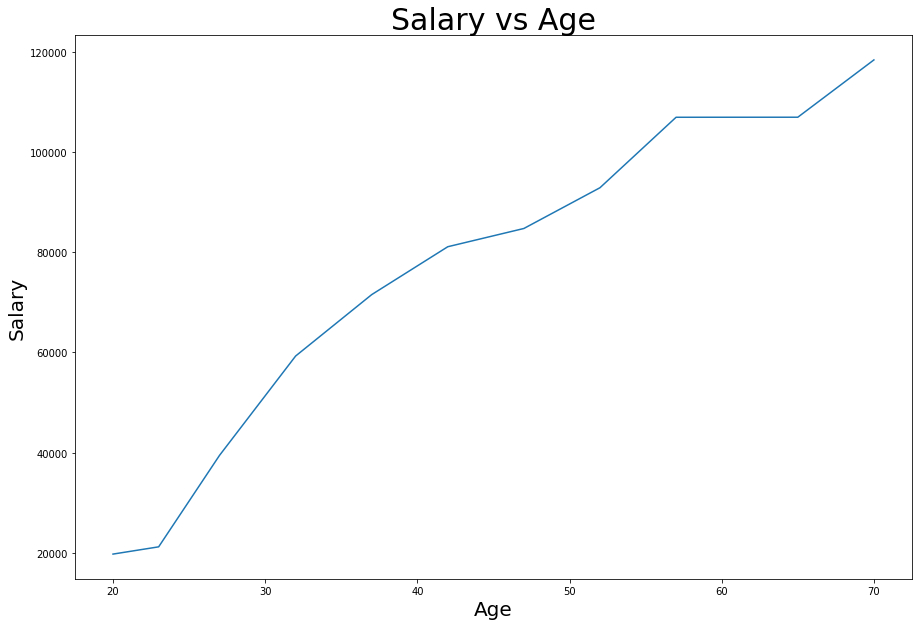

In [ ]:
salary_by_age = Age.groupby('Q1')
plt.figure(figsize=(15,10))
plt.xlabel('Age',fontsize=20)
plt.ylabel('Salary',fontsize=20)
plt.title('Salary vs Age',fontsize=30)
plt.plot(salary_by_age.mean())

##### 1.2.2 Gender and Salary
We plot the histogram and boxplot of male's salary and female's salary. Although males are more than females, their salary distributions are similar. The histogram of salary have similar shape. Comparing the boxplots between male and female salary, we can see they have similar ranges and outliers. The mean salary of male is just slightly higher than female. We can conclude that gender is not a crucial feature when predicting salary.  

In [ ]:
# Get the DataFrame of gender and salary only
gender = df[['Q2','Q10']]
gender['Q2'].value_counts()

Male                       10285
Female                      1773
Prefer not to say            162
Prefer to self-describe       30
Name: Q2, dtype: int64

In [ ]:
# Converting salary bucket into numbers
gender['Q10'] = gender['Q10'].map({'$0-999': 1000, '1,000-1,999': 2000, '2,000-2,999': 3000, '3,000-3,999': 4000, '4,000-4,999': 5000, '5,000-7,499': 7500, '7,500-9,999': 10000, '10,000-14,999': 15000, '15,000-19,999': 20000, '20,000-24,999': 25000, '25,000-29,999': 30000, '30,000-39,999': 40000, '40,000-49,999': 50000, '50,000-59,999': 60000, '60,000-69,999': 70000,  '70,000-79,999': 80000, '80,000-89,999': 90000, '90,000-99,999': 100000, '100,000-124,999': 125000, '125,000-149,999': 150000, '150,000-199,999': 200000, '200,000-249,999': 250000, '250,000-299,999': 300000, '300,000-500,000': 400000, '> $500,000': 500000})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


[Text(0, 0.5, 'Salary'),
 Text(0.5, 0, 'Female'),
 Text(0.5, 1.0, 'Boxplot of Female Salary')]

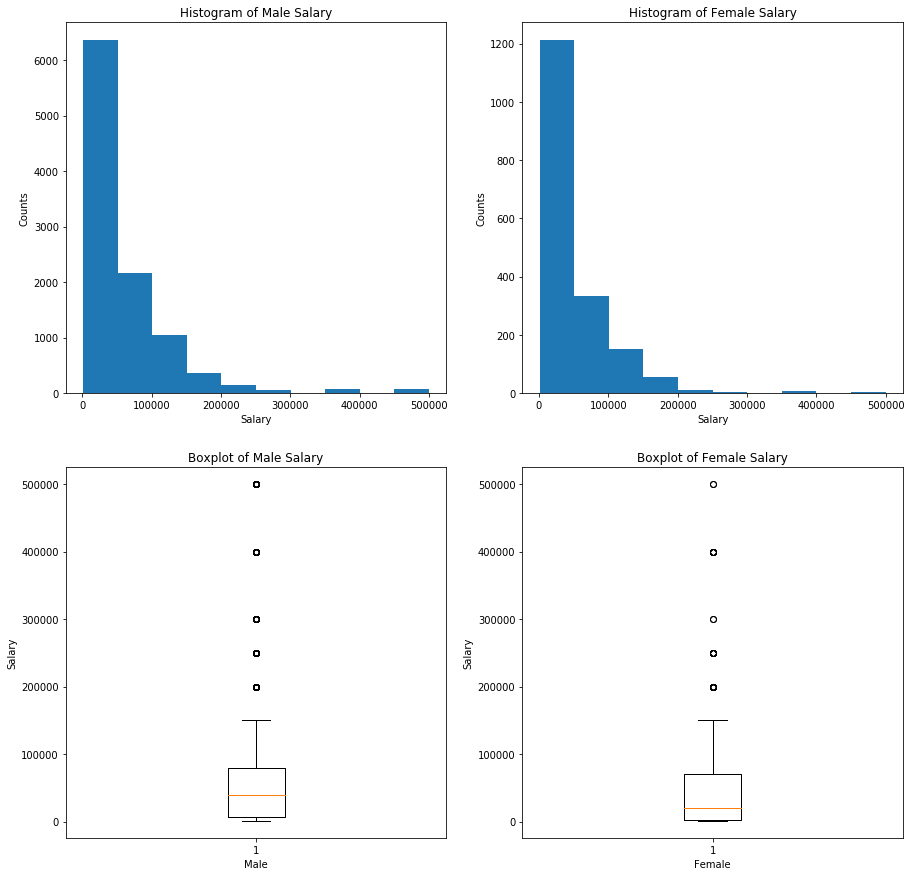

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
ax[0, 0].hist(gender[gender['Q2']=='Male']['Q10'])
ax[0, 0].set(xlabel='Salary',ylabel='Counts',title='Histogram of Male Salary')
ax[0, 1].hist(gender[gender['Q2']=='Female']['Q10'])
ax[0, 1].set(xlabel='Salary',ylabel='Counts',title='Histogram of Female Salary')
ax[1, 0].boxplot(gender[gender['Q2']=='Male']['Q10'])
ax[1, 0].set(xlabel='Male',ylabel='Salary',title='Boxplot of Male Salary')
ax[1, 1].boxplot(gender[gender['Q2']=='Female']['Q10'])
ax[1, 1].set(xlabel='Female',ylabel='Salary',title='Boxplot of Female Salary')

##### 1.2.3 Country and Salary
We catagorize country into "Europe/North America Area" and "Other Area" and compare the salary. From the histograms and boxplots, we can see the salary in Europe/North America is generally higher than other areas. The mean value and standard deviation of salary in Europe/North America area are higher than other areas. Therefore country is going to be an important feature when predicting salary. 



In [ ]:
# Get the DataFrame of country and salary only
country = df[['Q3','Q10']]

In [ ]:
country['Q3'].unique()

array(['France', 'India', 'Australia', 'United States of America',
       'Netherlands', 'Germany', 'Ireland', 'Russia', 'Greece', 'Ukraine',
       'Pakistan', 'Japan', 'Other', 'Brazil', 'South Korea', 'Belarus',
       'Nigeria', 'United Kingdom of Great Britain and Northern Ireland',
       'Sweden', 'Mexico', 'Canada', 'Portugal', 'Poland', 'Indonesia',
       'Italy', 'Czech Republic', 'Spain', 'Chile', 'Hong Kong (S.A.R.)',
       'South Africa', 'Argentina', 'Turkey', 'Israel', 'Taiwan', 'Egypt',
       'Morocco', 'Hungary', 'Colombia', 'Norway', 'Thailand',
       'Switzerland', 'Viet Nam', 'Singapore', 'Bangladesh',
       'Iran, Islamic Republic of...', 'Peru', 'Kenya', 'Romania',
       'China', 'Belgium', 'Austria', 'Algeria', 'New Zealand', 'Tunisia',
       'Philippines', 'Malaysia', 'Republic of Korea', 'Denmark',
       'Saudi Arabia'], dtype=object)

In [ ]:
# Converting salary bucket into numbers
country['Q10'] = country['Q10'].map({'$0-999': 1000, '1,000-1,999': 2000, '2,000-2,999': 3000, '3,000-3,999': 4000, '4,000-4,999': 5000, '5,000-7,499': 7500, '7,500-9,999': 10000, '10,000-14,999': 15000, '15,000-19,999': 20000, '20,000-24,999': 25000, '25,000-29,999': 30000, '30,000-39,999': 40000, '40,000-49,999': 50000, '50,000-59,999': 60000, '60,000-69,999': 70000,  '70,000-79,999': 80000, '80,000-89,999': 90000, '90,000-99,999': 100000, '100,000-124,999': 125000, '125,000-149,999': 150000, '150,000-199,999': 200000, '200,000-249,999': 250000, '250,000-299,999': 300000, '300,000-500,000': 400000, '> $500,000': 500000})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
Other_Area = ['India','Pakistan','Japan','Other','Brazil','South Korea',
              'Nigeria','Mexico','Indonesia','Chile', 'Hong Kong (S.A.R.)',
               'South Africa', 'Argentina','Israel', 'Taiwan', 'Egypt',
                'Morocco','Colombia','Thailand','Viet Nam', 'Singapore', 
              'Bangladesh','Iran, Islamic Republic of...', 'Peru', 'Kenya',
              'China','Algeria', 'New Zealand', 'Tunisia''Philippines',
              'Malaysia', 'Republic of Korea','Saudi Arabia']
country_list = list(country['Q3'])
for i in range (len(country_list)):
  if country_list[i] in Other_Area:
    country_list[i] = 'Other_Area'
  else:
    country_list[i] = 'Europe_NorthAmerica'
country['Q3'] = country_list

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
country['Q3'].value_counts()

Other_Area             6455
Europe_NorthAmerica    5795
Name: Q3, dtype: int64

[Text(0, 0.5, 'Salary'),
 Text(0.5, 0, 'Europe_NorthAmerica'),
 Text(0.5, 1.0, 'Boxplot of Europe_NorthAmerica Salary')]

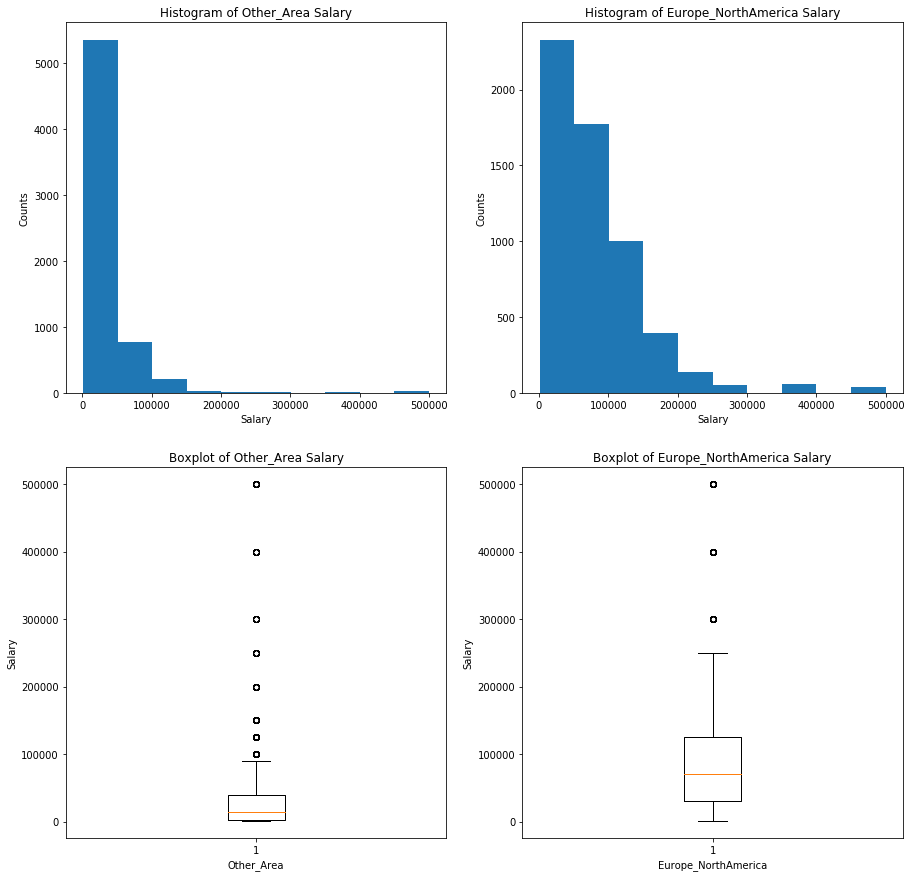

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(15,15))
ax[0, 0].hist(country[country['Q3']=='Other_Area']['Q10'])
ax[0, 0].set(xlabel='Salary',ylabel='Counts',title='Histogram of Other_Area Salary')
ax[0, 1].hist(country[country['Q3']=='Europe_NorthAmerica']['Q10'])
ax[0, 1].set(xlabel='Salary',ylabel='Counts',title='Histogram of Europe_NorthAmerica Salary')
ax[1, 0].boxplot(country[country['Q3']=='Other_Area']['Q10'])
ax[1, 0].set(xlabel='Other_Area',ylabel='Salary',title='Boxplot of Other_Area Salary')
ax[1, 1].boxplot(country[country['Q3']=='Europe_NorthAmerica']['Q10'])
ax[1, 1].set(xlabel='Europe_NorthAmerica',ylabel='Salary',title='Boxplot of Europe_NorthAmerica Salary')

### 1.3 Encoding
Ordinal encoding and one-hot encoding are used. For features which contains ranges (i.e. 3-5 years), we encode them by the mean values of the range and round to the upper integers. For catagorical features which we can say some inputs are better than other inputs (i.e. Doctoral better than Master), we also use ordinal encoding. The largest value is assigned to the best input. For features cannot diffrentiate which input is better (i.e. Python or Java), we use one-hot encoding. 

##### 1.3.1 Encoding Q1
Use the mean value of the given range, round to upper integers to encode the buckets. 

In [ ]:
df['Q1'].unique()

array(['22-24', '40-44', '50-54', '55-59', '30-34', '18-21', '35-39',
       '25-29', '45-49', '60-69', '70+'], dtype=object)

In [ ]:
df['Q1'] = df['Q1'].map({'22-24':23,'40-44':42,'50-54':52,'55-59':57,'30-34':32,'18-21':20,'35-39':37,'25-29':27,'45-49':47,'60-69':65,'70+':70})

##### 1.3.2 Encoding Q2
Use One-hot encoding

In [ ]:
df['Q2'].unique()

array(['Male', 'Female', 'Prefer to self-describe', 'Prefer not to say'],
      dtype=object)

In [ ]:
Q2_list = list(df['Q2'])
Q2_Male = []
Q2_Female = []
Q2_Unknown = []
for i in range (len(Q2_list)):
  if Q2_list[i] == 'Male':
    Q2_Male.append(1)
  else:
    Q2_Male.append(0)
  if Q2_list[i] == 'Female':
    Q2_Female.append(1)
  else:
    Q2_Female.append(0)
  if Q2_list[i] != 'Male' and Q2_list[i] != 'Female':
    Q2_Unknown.append(1)
  else:
    Q2_Unknown.append(0)

In [ ]:
df = df.drop(columns=['Q2'])

In [ ]:
df.insert(2,'Q2_Male',Q2_Male)
df.insert(3,'Q2_Female',Q2_Female)
df.insert(4,'Q2_Unknown',Q2_Unknown)

##### 1.3.3 Encoding Q3
Use Ordinal (Binary encoding): 1 for Europe/North America areas, 0 for other areas. 

In [ ]:
encoding_Q3 = []
for i in range (len(country_list)):
  if country_list[i] == 'Other_Area':
    encoding_Q3.append(0)
  else:
    encoding_Q3.append(1)

In [ ]:
df['Q3'] = encoding_Q3

##### 1.3.4 Encoding Q4
Use Ordinal encoding: 4 for Doctoral; 3 for Master; 2 for Bachelor; 1 for Some college/university study without earning a bachelor’s degree AND professional degree; 0 for No formal education past high school. Use the average of 2 for prefer not to answer.

In [ ]:
df['Q4'].unique()

array(['Master’s degree', 'Professional degree', 'Bachelor’s degree',
       'Doctoral degree',
       'Some college/university study without earning a bachelor’s degree',
       'I prefer not to answer', 'No formal education past high school'],
      dtype=object)

In [ ]:
list_Q4 = list(df['Q4'])
for i in range (len(list_Q4)):
  if list_Q4[i] == 'Doctoral degree':
    list_Q4[i] = 4
  elif list_Q4[i] == 'Master’s degree':
    list_Q4[i] = 3
  elif list_Q4[i] == 'Bachelor’s degree':
    list_Q4[i] = 2
  elif list_Q4[i] == 'Professional degree' or list_Q4[i] == 'Some college/university study without earning a bachelor’s degree':
    list_Q4[i] = 1
  elif list_Q4[i] == 'I prefer not to answer':
    list_Q4[i] = 2
  else:
    list_Q4[i] = 0

In [ ]:
df['Q4'] = list_Q4

##### 1.3.5 Encoding Q5
Use One-hot encoding

In [ ]:
df['Q5'].unique()

array(['Software Engineer', 'Other', 'Data Scientist', 'Statistician',
       'Product/Project Manager', 'Data Analyst', 'Research Scientist',
       'Business Analyst', 'Data Engineer', 'DBA/Database Engineer'],
      dtype=object)

In [ ]:
roles = df['Q5'].unique()
Q5_list = list(df['Q5'])
Q5_Part = [[],[],[],[],[],[],[],[],[],[]]
for i in range (len(Q5_list)):
  for j in range (len(roles)):
    if Q5_list[i] == roles[j]:
      Q5_Part[j].append(1)
    else:
      Q5_Part[j].append(0)

In [ ]:
df = df.drop(columns=['Q5'])

In [ ]:
for i in range (7,7+len(Q5_Part)):
  df.insert(i,'Q5_'+str(roles[i-7]),Q5_Part[i-7])

##### 1.3.6 Encoding Q6
Use the mean values rounding to upper integer to encode Q6

In [ ]:
df['Q6'].unique()

array(['1000-9,999 employees', '> 10,000 employees', '0-49 employees',
       '50-249 employees', '250-999 employees'], dtype=object)

In [ ]:
df['Q6'] = df['Q6'].map({'1000-9,999 employees':5000,'> 10,000 employees':10000,'0-49 employees':25,
                          '50-249 employees':150,'250-999 employees':625})


##### 1.3.7 Encodoing Q7
Use the mean values rounding to upper integer to encode Q7

In [ ]:
df['Q7'].unique()

array(['0', '20+', '3-4', '1-2', '5-9', '10-14', '15-19'], dtype=object)

In [ ]:
df['Q7'] = df['Q7'].map({'0':0,'20+':20,'3-4':4,'1-2':2,'5-9':7,'10-14':12,'15-19':17})


##### 1.3.8 Encoding Q8
Use ordinal encoding: 0 for No; 1 for 'insight'; 2 for 'exploring'; 3 for 'recently started'; 4 for 'Well established', average of 2 for 'don't know'

In [ ]:
df['Q8'].unique()

array(['I do not know',
       'We have well established ML methods (i.e., models in production for more than 2 years)',
       'No (we do not use ML methods)',
       'We are exploring ML methods (and may one day put a model into production)',
       'We recently started using ML methods (i.e., models in production for less than 2 years)',
       'We use ML methods for generating insights (but do not put working models into production)'],
      dtype=object)

In [ ]:
df['Q8'] = df['Q8'].map({'I do not know':2,
                         'We have well established ML methods (i.e., models in production for more than 2 years)':4,
                         'No (we do not use ML methods)':0,
                         'We are exploring ML methods (and may one day put a model into production)':2,
                         'We recently started using ML methods (i.e., models in production for less than 2 years)':3,
                         'We use ML methods for generating insights (but do not put working models into production)':1})

##### 1.3.9 Encoding Q11
Use the mean values rounding to upper integer to encode Q11

In [ ]:
df['Q11'].unique()

array(['$0 (USD)', '> $100,000 ($USD)', '$10,000-$99,999', '$100-$999',
       '$1000-$9,999', '$1-$99'], dtype=object)

In [ ]:
df['Q11'] = df['Q11'].map({'$0 (USD)':0,
                           '> $100,000 ($USD)':100000,
                           '$10,000-$99,999':55000,
                           '$100-$999':550,
                           '$1000-$9,999':5500,
                           '$1-$99':50})

##### 1.3.10 Encoding Q14
Use one-hot encoding

In [ ]:
df['Q14'].unique()

array(['Basic statistical software (Microsoft Excel, Google Sheets, etc.)',
       'Cloud-based data software & APIs (AWS, GCP, Azure, etc.)',
       'Local development environments (RStudio, JupyterLab, etc.)',
       'Advanced statistical software (SPSS, SAS, etc.)', 'Other',
       'Business intelligence software (Salesforce, Tableau, Spotfire, etc.)'],
      dtype=object)

In [ ]:
df.columns.get_loc('Q14')

54

In [ ]:
tools = df['Q14'].unique()
Q14_list = list(df['Q14'])
Q14_Part = [[],[],[],[],[],[]]
for i in range (len(Q14_list)):
  for j in range (len(tools)):
    if Q14_list[i] == tools[j]:
      Q14_Part[j].append(1)
    else:
      Q14_Part[j].append(0)

In [ ]:
df = df.drop(columns=['Q14'])
for i in range (54,54+len(Q14_Part)):
  df.insert(i,'Q14_'+str(tools[i-54]),Q14_Part[i-54])

1.3.11 Encoding Q15
Use the mean values rounding to upper integer to encode Q15

In [ ]:
df['Q15'].unique()

array(['1-2 years', 'I have never written code', '< 1 years', '20+ years',
       '3-5 years', '5-10 years', '10-20 years', nan], dtype=object)

In [ ]:
df['Q15'] = df['Q15'].map({'1-2 years':2,
                           'I have never written code':0,
                           '< 1 years':1,
                           '20+ years':20,
                           '3-5 years':4,
                           '5-10 years':8,
                           '10-20 years':15})

In [ ]:
df['Q15']

0         2.0
1         0.0
2         2.0
3         1.0
4        20.0
         ... 
12490     NaN
12491     NaN
12492     NaN
12494     2.0
12496     4.0
Name: Q15, Length: 12250, dtype: float64

In [ ]:
df['Q15'] = df['Q15'].fillna(int(df['Q15'].mean()))

##### 1.3.12 Encoding Q19
Use one-hot encoding

In [ ]:
df['Q19'].unique()

array(['Python', 'Java', 'R', 'SQL', 'C++', 'None', 'Other', 'C',
       'MATLAB', 'TypeScript', 'Javascript', 'Bash'], dtype=object)

In [ ]:
df.columns.get_loc('Q19')

97

In [ ]:
language = df['Q19'].unique()
Q19_list = list(df['Q19'])
Q19_Part = [[],[],[],[],[],[],[],[],[],[],[],[]]
for i in range (len(Q19_list)):
  for j in range (len(language)):
    if Q19_list[i] == language[j]:
      Q19_Part[j].append(1)
    else:
      Q19_Part[j].append(0)

In [ ]:
df = df.drop(columns=['Q19'])
for i in range (97,97+len(Q19_Part)):
  df.insert(i,'Q19_'+str(language[i-97]),Q19_Part[i-97])

##### 1.3.13 Encoding Q23
Use the mean values rounding to upper integer to encode Q23

In [ ]:
df['Q23'].unique()

array(['1-2 years', nan, '2-3 years', '< 1 years', '10-15 years',
       '3-4 years', '4-5 years', '5-10 years', '20+ years'], dtype=object)

In [ ]:
df['Q23'] = df['Q23'].map({'1-2 years':2,
                           '2-3 years':3,
                           '< 1 years':1,
                           '10-15 years':13,
                           '3-4 years':4,
                           '4-5 years':5,
                           '5-10 years':8,
                           '20+ years':20})

In [ ]:
df['Q23'] = df['Q23'].fillna(int(df['Q23'].mean()))

##### 1.3.14 Encoding All Multiple Choice Questions
1 for entries, 0 for Nan

In [ ]:
# drop Q10
df = df.drop(columns=['Q10'])

In [ ]:
for i in range (len(df.columns)):
  if 'Part' in df.columns[i]:
    df[df.columns[i]] = df[df.columns[i]].fillna(0)

In [ ]:
for i in range (len(df.columns)):
  if 'Part' in df.columns[i]:
    if df[df.columns[i]].unique()[0] != 0:
      entry = df[df.columns[i]].unique()[0]
    else:
      entry = df[df.columns[i]].unique()[1]
    df[df.columns[i]] = df[df.columns[i]].replace(to_replace =entry, 
                 value =1)

### 1.4 Feature Importance
Use random forest to evaluate feature importance. 

##### 1.4.1 Train Model

In [ ]:
X = df.iloc[:,0:-2]
X_std = MinMaxScaler().fit_transform(X)
y = df.iloc[:,-2]
# Create decision tree classifer object
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# Train model
model = clf.fit(X_std, y)

In [ ]:
# Calculate feature importances
importances = model.feature_importances_

##### 1.4.2 Visualize Feature Importance

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:4291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future thi

<BarContainer object of 50 artists>

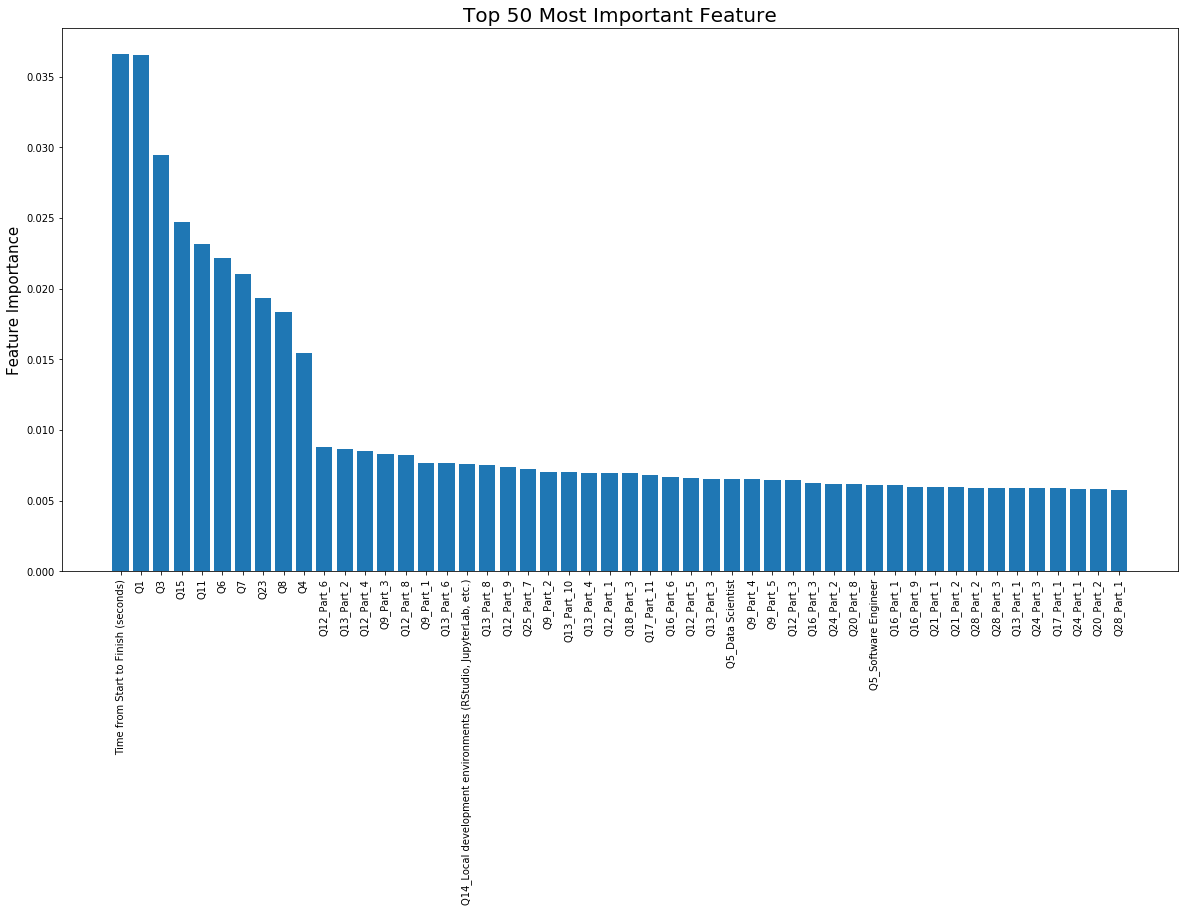

In [ ]:
Feature_name = X.columns
indices = importances.argsort()[::-1][0:50]
importances[[indices]]
Feature_name[[indices]]
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.ylabel('Feature Importance',fontsize=15)
plt.title('Top 50 Most Important Feature',fontsize=20)
plt.bar(Feature_name[[indices]],importances[[indices]])

##### 1.4.3 Results
From the visualization, we can see "Time from Start to Finish", "Q1", "Q3", "Q15", "Q11", "Q6", "Q7", "Q23", "Q8", "Q4" are outstandingly informative features. 

# 2.0 Feature Selection
A feature could be strongly relevant (i.e., the feature has information that doesn't exist in any other feature), relevant, weakly relevant (some information that other features include) or irrelevant. Reducing the features by feature selection can reduce the complexity of the model, thus the model can run faster.[1]Feature selection can be used to prevent overfitting. Even if some features are irrelevant, having too many is better than missing those that are important. Feature selection can be done manually, but this can be inaccurate without domain experts. The Lasso regularization has the property that is able to shrink some of the coefficients to zero. Since each non-zero coefficient adds to the penalty, it forces weak features to have zero as coefficients. Therefore, we will use Lasso regularization feature selection algorithm.

### 2.1 Use Lasso Regularization to Extract Features
Use alpha = 0.01, so that the penalization term is not very large. This can reduce the chance of missing important features. 

In [ ]:
fs = Lasso(alpha=0.01)
fs.fit(X_std,y)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
select = []
for i in range (len(fs.coef_)):
  if fs.coef_[i] != 0:
    select.append(i)

In [ ]:
Feature_name[select]

Index(['Q1', 'Q2_Female', 'Q3', 'Q5_Other', 'Q5_Data Scientist',
       'Q5_Product/Project Manager', 'Q5_Data Analyst',
       'Q5_Research Scientist', 'Q6', 'Q7', 'Q8', 'Q9_Part_1', 'Q9_Part_2',
       'Q9_Part_3', 'Q9_Part_4', 'Q9_Part_5', 'Q9_Part_6', 'Q11', 'Q12_Part_1',
       'Q12_Part_2', 'Q12_Part_3', 'Q12_Part_4', 'Q12_Part_5', 'Q12_Part_6',
       'Q12_Part_7', 'Q12_Part_8', 'Q12_Part_9', 'Q12_Part_10', 'Q13_Part_1',
       'Q13_Part_2', 'Q13_Part_3', 'Q13_Part_4', 'Q13_Part_6', 'Q13_Part_7',
       'Q13_Part_8', 'Q13_Part_12',
       'Q14_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)',
       'Q14_Local development environments (RStudio, JupyterLab, etc.)',
       'Q14_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)',
       'Q15', 'Q16_Part_1', 'Q16_Part_3', 'Q16_Part_4', 'Q16_Part_5',
       'Q16_Part_6', 'Q16_Part_7', 'Q16_Part_8', 'Q16_Part_9', 'Q16_Part_10',
       'Q17_Part_1', 'Q17_Part_2', 'Q17_Part_11', 'Q18_Part_3', 'Q18_Part_4',
  

### 2.2 Final Selection
The features selected by L1 regularization was listed above. We find out the Lasso Regularization did not include "Q4-highest education level". The previous randon forest model indicate Q4 is an important feature. Also by common sense, education level will match to salary level. So, we manually add Q4 to the selected features. 

In [ ]:
Selected = ['Q1', 'Q2_Female', 'Q3', 'Q5_Other', 'Q5_Data Scientist',
       'Q5_Product/Project Manager', 'Q5_Data Analyst',
       'Q5_Research Scientist', 'Q6', 'Q7', 'Q8', 'Q9_Part_1', 'Q9_Part_2',
       'Q9_Part_3', 'Q9_Part_4', 'Q9_Part_5', 'Q9_Part_6', 'Q11', 'Q12_Part_1',
       'Q12_Part_2', 'Q12_Part_3', 'Q12_Part_4', 'Q12_Part_5', 'Q12_Part_6',
       'Q12_Part_7', 'Q12_Part_8', 'Q12_Part_9', 'Q12_Part_10', 'Q13_Part_1',
       'Q13_Part_2', 'Q13_Part_3', 'Q13_Part_4', 'Q13_Part_6', 'Q13_Part_7',
       'Q13_Part_8', 'Q13_Part_12',
       'Q14_Cloud-based data software & APIs (AWS, GCP, Azure, etc.)',
       'Q14_Local development environments (RStudio, JupyterLab, etc.)',
       'Q14_Business intelligence software (Salesforce, Tableau, Spotfire, etc.)',
       'Q15', 'Q16_Part_1', 'Q16_Part_3', 'Q16_Part_4', 'Q16_Part_5',
       'Q16_Part_6', 'Q16_Part_7', 'Q16_Part_8', 'Q16_Part_9', 'Q16_Part_10',
       'Q17_Part_1', 'Q17_Part_2', 'Q17_Part_11', 'Q18_Part_3', 'Q18_Part_4',
       'Q18_Part_5', 'Q18_Part_6', 'Q18_Part_9', 'Q19_SQL', 'Q20_Part_2',
       'Q20_Part_5', 'Q20_Part_6', 'Q21_Part_1', 'Q21_Part_2', 'Q21_Part_4',
       'Q23', 'Q24_Part_1', 'Q24_Part_3', 'Q24_Part_9', 'Q24_Part_10',
       'Q25_Part_6', 'Q25_Part_7', 'Q26_Part_6', 'Q27_Part_5', 'Q28_Part_5',
       'Q29_Part_2', 'Q29_Part_11', 'Q30_Part_1', 'Q30_Part_6', 'Q30_Part_11',
       'Q31_Part_1', 'Q31_Part_2', 'Q31_Part_7', 'Q32_Part_3', 'Q32_Part_11',
       'Q33_Part_11', 'Q34_Part_1', 'Q34_Part_3', 'Q34_Part_5', 'Q34_Part_6',
       'Q34_Part_7','Q4']

# 3.0 Model Implementation

### 3.1 Get the Training and Testing Sets
Use MinMax Scalar to scale the features. The one-hot encoding will not be affected by MinMax Scalar. They still remain as 0 and 1 after scaling. 

In [ ]:
# Drop the unselected features
Useless = []
for i in range (len(X.columns)):
  if X.columns[i] not in Selected:
     Useless.append(i)
X = X.drop(X.columns[Useless], axis=1)

In [ ]:
X_std = MinMaxScaler().fit_transform(X)
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=0)

### 3.2 Implement the Logistic Regression 10- Fold CV
For the model we use orinary multi-class classification algorithm. There are 15 different lables in the target set, so 15 binary classifications are implemented. For each binary classifications, a logistic regression is trained. Then the prediction is made by output the probability of belonging to 0 or 1. For classification problem 1, we have class 0 for salary 0-10K and class 1 for the rest. For classification problem 2, we have class 0 for salary 0-20K and class 1 for the rest. We can obtain the probability of each data point of belonging to each of the salary buckets, and select the label with highest probability as the prediction.  

In [ ]:
def binary_y(y,b):
  y1 = np.zeros(len(y))
  for i in range(len(y)):
    if y[i] <= b:
      y1[i] = 1
    else: 
      y1[i] = 0
  return y1

In [ ]:


# acc = []
# fold = 0
# kf = KFold(n_splits=10)
# for train_index, test_index in kf.split(X_train):
#   fold += 1
#   X_trainCV = X_train[train_index]
#   y_trainCV = y_train[train_index]
#   X_val = X_train[test_index]
#   y_val = y_train[test_index]
#   P = np.zeros((len(y_val),15))
#   for i in range (14):
#     #print("TRAIN:", train_index, "TEST:", test_index)
#     lr = LogisticRegression(max_iter=10000).fit(X_trainCV, binary_y(y_trainCV,i))
#     pred = lr.predict_proba(X_val)
#     P[:,i] = pred[:,1]
#   for i in range (1,14):
#     P[:,i] = P[:,i] - np.sum(P[:,0:i], axis=1)
#     P[:,14] = 1-np.sum(P[:,0:-1],axis=1)
#     predict = P.argmax(axis=1)
#   print('Accuracy of fold' + str(fold) + ':' + str(accuracy_score(y_val,predict)))
#   acc.append(accuracy_score(y_val,predict))
# print('Model Accuracy: ' +str(np.array(acc).mean()))
# print('Accuracy Standard Deviation: ' +str(np.array(acc).std()))



Accuracy of fold1:0.33979591836734696
Accuracy of fold2:0.36428571428571427
Accuracy of fold3:0.35612244897959183
Accuracy of fold4:0.3326530612244898
Accuracy of fold5:0.3142857142857143
Accuracy of fold6:0.363265306122449
Accuracy of fold7:0.3306122448979592
Accuracy of fold8:0.3438775510204082
Accuracy of fold9:0.34183673469387754
Accuracy of fold10:0.32755102040816325
Model Accuracy: 0.3414285714285714
Accuracy Standard Deviation: 0.01532108112581507


### 3.3 Bias and Variance
The mean accuracy of the model is 0.344 and standard deviation of 0.017. The bias of the model is very high, but the variance is not very large. We have to do bias-variance trade off to reduce the bias by hyperparameter tuning. 

# 4.0 Hyperparameter Tuning
For each binary classification, we are going to tune its own best hyperparameter and solver. We use accuracy as metrics because the data is fairly balanced. In the case of salary prediction, false positive and false negative are equally bad. Accuracy assign same penalization on each case. 

### 4.1 Grid Research

In [ ]:
# for i in range (14):
#     best_model = model
#     best_params = {}
#     best_accuracy = 0
#     best_std = 0

#     for C in [0.001,0.01,0.05,0.1,0.5,1,5,10]:
#         for solver in ['newton-cg','lbfgs','liblinear','sag']:
#             accuracy = []

#             for train_index, test_index in kf.split(X_train):
#               X_trainCV = X_train[train_index]
#               y_trainCV = y_train[train_index]
#               X_val = X_train[test_index]
#               y_val = y_train[test_index]
#               P = np.zeros((len(y_val),15))

#               model = LogisticRegression(random_state=0,C=C,penalty='l2',max_iter=10000,solver=solver).fit(X_trainCV, binary_y(y_trainCV,i))
#               pred = model.predict(X_val)

#               accuracy.append(accuracy_score(binary_y(y_val,i),pred))
            
#             if np.array(accuracy).mean() > best_accuracy:
#                 best_model = model
#                 best_params = {'C':C, 'solver':solver}
#                 best_accuracy = np.array(accuracy).mean()
#                 best_std = np.array(accuracy).std()

#     print (best_params)
#     print ("Best Score: {}({})".format(round(best_accuracy,3),round(best_std,3)))      
#     print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {} with a standard deviation of {}".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 0.5, 'solver': 'liblinear'}
Best Score: 0.784(0.013)

The optimal log model uses C=0.5, and a liblinear solver, and has a cross validation score of 0.784 with a standard deviation of 0.013
{'C': 0.5, 'solver': 'newton-cg'}
Best Score: 0.778(0.012)

The optimal log model uses C=0.5, and a newton-cg solver, and has a cross validation score of 0.778 with a standard deviation of 0.012
{'C': 1, 'solver': 'liblinear'}
Best Score: 0.781(0.016)

The optimal log model uses C=1, and a liblinear solver, and has a cross validation score of 0.781 with a standard deviation of 0.016
{'C': 0.5, 'solver': 'liblinear'}
Best Score: 0.779(0.017)

The optimal log model uses C=0.5, and a liblinear solver, and has a cross validation score of 0.779 with a standard deviation of 0.017
{'C': 0.1, 'solver': 'liblinear'}
Best Score: 0.788(0.011)

The optimal log model uses C=0.1, and a liblinear solver, and has a cross validation score of 0.788 with a standard deviation of 0.011
{'C': 0.5, 'solver': 'newton-

### 4.2 Best Hyperparameters on each binary classifier
We implement the tuned hyperparameter on each classification and see how the model perform. The model accuracy decreases and variance increases. The model perform even worse than section 3.2. Tuning the hyperparameters for each binary classification does not increase the model performance. We are going to try to use universal hyperparameters for all the binary classifications.

In [ ]:
C = [0.5, 0.5, 1, 0.5, 0.1, 0.5, 0.5, 0.05, 0.05, 0.1, 0.5, 0.05, 0.1, 0.1]
solver = ['liblinear','newton-cg','newton-cg','liblinear','liblinear','newton-cg','newton-cg','newton-cg','newton-cg','newton-cg','newton-cg','liblinear','newton-cg','newton-cg']

In [ ]:
# acc = []
# fold = 0
# kf = KFold(n_splits=10)
# for train_index, test_index in kf.split(X_train):
#   fold += 1
#   X_trainCV = X_train[train_index]
#   y_trainCV = y_train[train_index]
#   X_val = X_train[test_index]
#   y_val = y_train[test_index]
#   P = np.zeros((len(y_val),15))
#   for i in range (14):
#     #print("TRAIN:", train_index, "TEST:", test_index)
#     lr = LogisticRegression(C=C[i],solver=solver[i],max_iter=10000).fit(X_trainCV, binary_y(y_trainCV,i))
#     pred = lr.predict_proba(X_val)
#     P[:,i] = pred[:,1]
#   for i in range (1,14):
#     P[:,i] = P[:,i] - np.sum(P[:,0:i], axis=1)
#     P[:,14] = 1-np.sum(P[:,0:-1],axis=1)
#     predict = P.argmax(axis=1)
#   print('Accuracy of fold' + str(fold) + ':' + str(accuracy_score(y_val,predict)))
#   acc.append(accuracy_score(y_val,predict))
# print('Model Accuracy: ' +str(np.array(acc).mean()))
# print('Accuracy Standard Deviation: ' +str(np.array(acc).std()))

Accuracy of fold1:0.3346938775510204
Accuracy of fold2:0.3653061224489796
Accuracy of fold3:0.35408163265306125
Accuracy of fold4:0.32551020408163267
Accuracy of fold5:0.3163265306122449
Accuracy of fold6:0.3683673469387755
Accuracy of fold7:0.32857142857142857
Accuracy of fold8:0.34183673469387754
Accuracy of fold9:0.33877551020408164
Accuracy of fold10:0.32857142857142857
Model Accuracy: 0.3402040816326531
Accuracy Standard Deviation: 0.01645485285330713


### 4.3 Grid Research on Model Hyperparameters
For each binary classification, we will use the same hyperparameter. In this section we tune the "universal hyperparameter" for the model and find out the best combination is C = 0.05 and solver = newton-cg. The accuracy of the model is 0.3466 and standard deviation is 0.0159. Comparing to section 3.2, the model bias decreases but variance increases. 

In [ ]:
def clf10(R,S):
  acc = []
  fold = 0
  kf = KFold(n_splits=10)
  for train_index, test_index in kf.split(X_train):
    fold += 1
    X_trainCV = X_train[train_index]
    y_trainCV = y_train[train_index]
    X_val = X_train[test_index]
    y_val = y_train[test_index]
    P = np.zeros((len(y_val),15))
    for i in range (14):
      #print("TRAIN:", train_index, "TEST:", test_index)
      lr = LogisticRegression(max_iter=10000,C=R,solver=S).fit(X_trainCV, binary_y(y_trainCV,i))
      pred = lr.predict_proba(X_val)
      P[:,i] = pred[:,1]
    for i in range (1,14):
      P[:,i] = P[:,i] - np.sum(P[:,0:i], axis=1)
      P[:,14] = 1-np.sum(P[:,0:-1],axis=1)
      predict = P.argmax(axis=1)
    acc.append(accuracy_score(y_val,predict))
  print('Model Accuracy: ' +str(np.array(acc).mean()))
  print('Accuracy Standard Deviation: ' +str(np.array(acc).std()))

In [ ]:
# for C in [0.001,0.01,0.05,0.1,0.5,1,5,10]:
#     for solver in ['newton-cg','lbfgs','liblinear','sag']:
#       print(C,solver)
#       clf10(C,solver)

0.001 newton-cg
Model Accuracy: 0.3233673469387755
Accuracy Standard Deviation: 0.01658877397240491
0.001 lbfgs
Model Accuracy: 0.3233673469387755
Accuracy Standard Deviation: 0.01658877397240491
0.001 liblinear
Model Accuracy: 0.32112244897959186
Accuracy Standard Deviation: 0.014906692994870303
0.001 sag
Model Accuracy: 0.3233673469387755
Accuracy Standard Deviation: 0.01658877397240491
0.01 newton-cg
Model Accuracy: 0.3451020408163265
Accuracy Standard Deviation: 0.015514231485711865
0.01 lbfgs
Model Accuracy: 0.3451020408163265
Accuracy Standard Deviation: 0.015514231485711865
0.01 liblinear
Model Accuracy: 0.3446938775510204
Accuracy Standard Deviation: 0.01817816403399458
0.01 sag
Model Accuracy: 0.3451020408163265
Accuracy Standard Deviation: 0.015514231485711865
0.05 newton-cg
Model Accuracy: 0.3466326530612245
Accuracy Standard Deviation: 0.015939611674217938
0.05 lbfgs
Model Accuracy: 0.346530612244898
Accuracy Standard Deviation: 0.01598624981842134
0.05 liblinear
Model Accu

In [ ]:
# clf10(0.05,'newton-cg')

Model Accuracy: 0.3466326530612245
Accuracy Standard Deviation: 0.015939611674217938


# 5.0 Test and Discussion

### 5.1 Implement the Model on Train and Test Data

In [ ]:
P_test = np.zeros((len(y_train),15))
for i in range (14):
    TEST = LogisticRegression(random_state=0,C=0.05,solver='newton-cg',penalty='l2',max_iter=10000).fit(X_train, binary_y(y_train,i))
    pred = TEST.predict_proba(X_train)
    P_test[:,i] = pred[:,1]
for i in range (1,14):
    P_test[:,i] = P_test[:,i] - np.sum(P_test[:,0:i], axis=1)
    P_test[:,14] = 1-np.sum(P_test[:,0:-1],axis=1)
    predict = P_test.argmax(axis=1)
print('The train accuracy after tuning is: ' +str(accuracy_score(y_train,predict)))

The train accuracy after tuning is: 0.3660204081632653


In [ ]:
P_test = np.zeros((len(y_test),15))
for i in range (14):
    TEST = LogisticRegression(random_state=0,C=0.05,solver='newton-cg',penalty='l2',max_iter=10000).fit(X_train, binary_y(y_train,i))
    pred = TEST.predict_proba(X_test)
    P_test[:,i] = pred[:,1]
for i in range (1,14):
    P_test[:,i] = P_test[:,i] - np.sum(P_test[:,0:i], axis=1)
    P_test[:,14] = 1-np.sum(P_test[:,0:-1],axis=1)
    predict = P_test.argmax(axis=1)
print('The test accuracy after tuning is: ' +str(accuracy_score(y_test,predict)))

The test accuracy after tuning is: 0.3497959183673469


### 5.2 Plot the Distribution

Text(0.5, 1.0, 'Comparing the Distribution of Predicted Label and True Label')

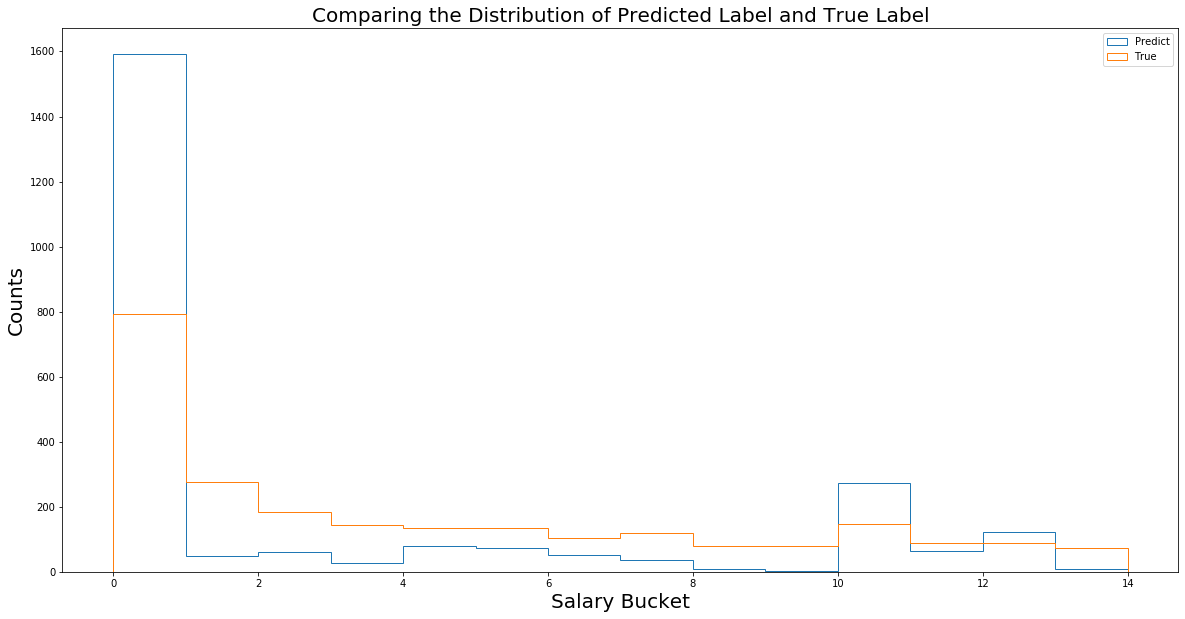

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(predict,histtype='step',label='Predict',bins=14)
plt.hist(y_test,histtype='step',label='True',bins=14)
plt.xlabel('Salary Bucket',fontsize=20)
plt.ylabel('Counts',fontsize=20)
plt.legend()
plt.title('Comparing the Distribution of Predicted Label and True Label',fontsize=20)

### 5.3 Discussion
The accuracy is 0.366 on training set and 0.35 on testing set. The model's performance on training and testing set are very similar, so the model is not overfit. However, the model is clearly underfit. The accuracy on both training and testing set are low, which means the model cannot predict the label properly. From the plot in section 5.2, we can observe that the model generally predict the salary lower than the actual value. The predicted distribution is more skewed than actual because the model mistakenly labeled too many data points as "0". If we want to obtain higher accuracy and overcome the underfitting issue, a more complexed model (other than linear classifier) should be chosen. The model uses ordinary multi-class algorithm, which implements 15 binary classification. Clearly, logistic regression performed very poorly even on simple binary classification. So we can speculate that the data points are not linearly seperable. If we implement some non-linear classifier such as KNN or neural netwrok to train the data, the model accuracy could be better. However, if we use more complexed model, overfitting will become an issue. It's also important to do hyperparameter tuning and cross validation for other algorithms. 

[1] https://www.cs.princeton.edu/courses/archive/spring10/cos424/slides/18-feat.pdf